In [1]:
from jax.config import config; config.update("jax_enable_x64", True)
from jax.random import PRNGKey, split
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from collapse import compute_feature_collapse, best_fit_line
from network import init_net, compute_outputs
from loss import create_loss
from solver import train
from data import generate_orthogonal_input, generate_labels_and_target

## Intro Figure

In [3]:
key = PRNGKey(0)

num_classes = 5
num_samples_per_class = 10
total_samples = num_classes * num_samples_per_class
input_dim = total_samples

labels, target = generate_labels_and_target(num_classes, num_samples_per_class)

key, subkey = split(key)
input_data = generate_orthogonal_input(subkey, input_dim, total_samples)

depth = 8
init_scale = 0.5

loss_fn = create_loss(target)
loss_fn_dict = {
    'train': loss_fn
}

linear_network_fn = lambda w: compute_outputs(w, input_data, nonlinear=False)[0]
nonlinear_network_fn = lambda w: compute_outputs(w, input_data, nonlinear=True)[0]

key, subkey = split(key)
init_weights = init_net(
    key=subkey, 
    input_dim=input_dim, 
    output_dim=num_classes, 
    width=input_dim, 
    depth=depth, 
    init_scale=init_scale
)

tol = 1e-6
n_outer_loops = 5000
n_inner_loops = 100
step_size = 1

In [ ]:
linear_result = train(
    init_weights=init_weights,
    network_fn=linear_network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    tol=tol,
    n_inner_loops=n_inner_loops
)

linear_final_weights = linear_result['final_weights']

In [ ]:
nonlinear_result = train(
    init_weights=init_weights,
    network_fn=nonlinear_network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    tol=tol,
    n_inner_loops=n_inner_loops
)

nonlinear_final_weights = nonlinear_result['final_weights']

In [ ]:
linear_intermediate_outputs = compute_outputs(linear_final_weights, input_data, nonlinear=False)[1]

linear_feature_collapse_per_layer = jnp.array([
    compute_feature_collapse(inter_out, labels) for inter_out in linear_intermediate_outputs
])

nonlinear_intermediate_outputs = compute_outputs(nonlinear_final_weights, input_data, nonlinear=True)[1]

nonlinear_feature_collapse_per_layer = jnp.array([
    compute_feature_collapse(inter_out, labels) for inter_out in nonlinear_intermediate_outputs
])

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(19, 7))
axes[0].semilogy(best_fit_line(linear_feature_collapse_per_layer), c='tab:blue', linewidth=8)
axes[0].semilogy(linear_feature_collapse_per_layer, 'o', c='black', markersize=20)
axes[0].set_xlabel(r'Layer Index (Shallow $\rightarrow$ Deep)', fontsize=25)
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_ylabel('Separation Measure', fontsize=25)
axes[0].set_title('Deep Linear Network', fontsize=25)

axes[0].tick_params(axis='both', which='major', labelsize=20)

axes[1].semilogy(best_fit_line(nonlinear_feature_collapse_per_layer), c='tab:blue', linewidth=8)
axes[1].semilogy(nonlinear_feature_collapse_per_layer, 'o', c='black', markersize=20)
axes[1].set_xlabel(r'Layer Index (Shallow $\rightarrow$ Deep)', fontsize=25)
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Separation Measure', fontsize=25)
axes[1].set_title('Deep Nonlinear Network', fontsize=25);

axes[1].tick_params(axis='both', which='major', labelsize=20)

# plt.savefig('figs/collapse_intro.png', dpi=300, bbox_inches='tight')

## Grid

In [ ]:
i = 0
fig = plt.figure(figsize=(23, 11))

for nonlinear in [False, True]:
    
    network_fn = nonlinear_network_fn if nonlinear else linear_network_fn
    for depth in [6, 8, 10]:
        
        i += 1
        
        key, subkey = split(key)
        init_weights = init_net(
            key=subkey, 
            input_dim=input_dim, 
            output_dim=num_classes, 
            width=input_dim, 
            depth=depth, 
            init_scale=init_scale
        )
        
        result = train(
            init_weights=init_weights,
            network_fn=network_fn,
            loss_fn_dict=loss_fn_dict,
            n_outer_loops=n_outer_loops,
            step_size=step_size,
            tol=tol,
            n_inner_loops=n_inner_loops
        )

        final_weights = result['final_weights']
        intermediate_outputs = compute_outputs(final_weights, input_data, nonlinear=nonlinear)[1]

        feature_collapse_per_layer = jnp.array([
            compute_feature_collapse(inter_out, labels) for inter_out in intermediate_outputs
        ])
        
        ax = fig.add_subplot(2, 3, i)
        ax.semilogy(best_fit_line(feature_collapse_per_layer), c='tab:blue', linewidth=8)
        ax.semilogy(feature_collapse_per_layer, 'o', c='black', markersize=20)
        ax.set_xlabel(r'Layer Index ($l$)', fontsize=25)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_ylabel('$D_l$', fontsize=25)
        ax.set_title(f'$L={depth}$, ' + ('ReLU' if nonlinear else 'Linear') + ' Activation', fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=18)

fig.tight_layout()
# plt.savefig('figs/grid_collapse.png', dpi=300, bbox_inches='tight')

## Supplement - changing init scale

In [ ]:
fig = plt.figure(figsize=(16, 7))

step_sizes = [1e1, 1e1, 1e1]
depth = 4

for i, nonlinear in enumerate([False, True]):
    
    ax = fig.add_subplot(1, 2, i+1)
    
    network_fn = nonlinear_network_fn if nonlinear else linear_network_fn
    for j, init_scale in enumerate([5e-1, 2.5e-1, 1.25e-1]):
        
        print(f"{nonlinear=}", f"{init_scale=}")
        
        key, subkey = split(key)
        init_weights = init_net(
            key=subkey, 
            input_dim=input_dim, 
            output_dim=num_classes, 
            width=input_dim, 
            depth=depth, 
            init_scale=init_scale
        )
        
        result = train(
            init_weights=init_weights,
            network_fn=network_fn,
            loss_fn_dict=loss_fn_dict,
            n_outer_loops=n_outer_loops,
            step_size=step_sizes[j],
            tol=tol,
            n_inner_loops=n_inner_loops
        )

        final_weights = result['final_weights']
        intermediate_outputs = compute_outputs(final_weights, input_data, nonlinear=nonlinear)[1]

        feature_collapse_per_layer = jnp.array([
            compute_feature_collapse(inter_out, labels) for inter_out in intermediate_outputs
        ])
        
        ax.semilogy(best_fit_line(feature_collapse_per_layer), linewidth=8, label='$\epsilon=$' + str(init_scale))
        ax.semilogy(feature_collapse_per_layer, 'o', c='black', markersize=20)
        
    ax.set_xlabel(r'Layer Index ($l$)', fontsize=25)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('$D_l$', fontsize=25)
    ax.set_title(('ReLU' if nonlinear else 'Linear') + ' Activation', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.legend(fontsize=20)

fig.tight_layout()
plt.savefig('figs/init_scale_collapse.png', dpi=300, bbox_inches='tight')

## Supplement - initialization types

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

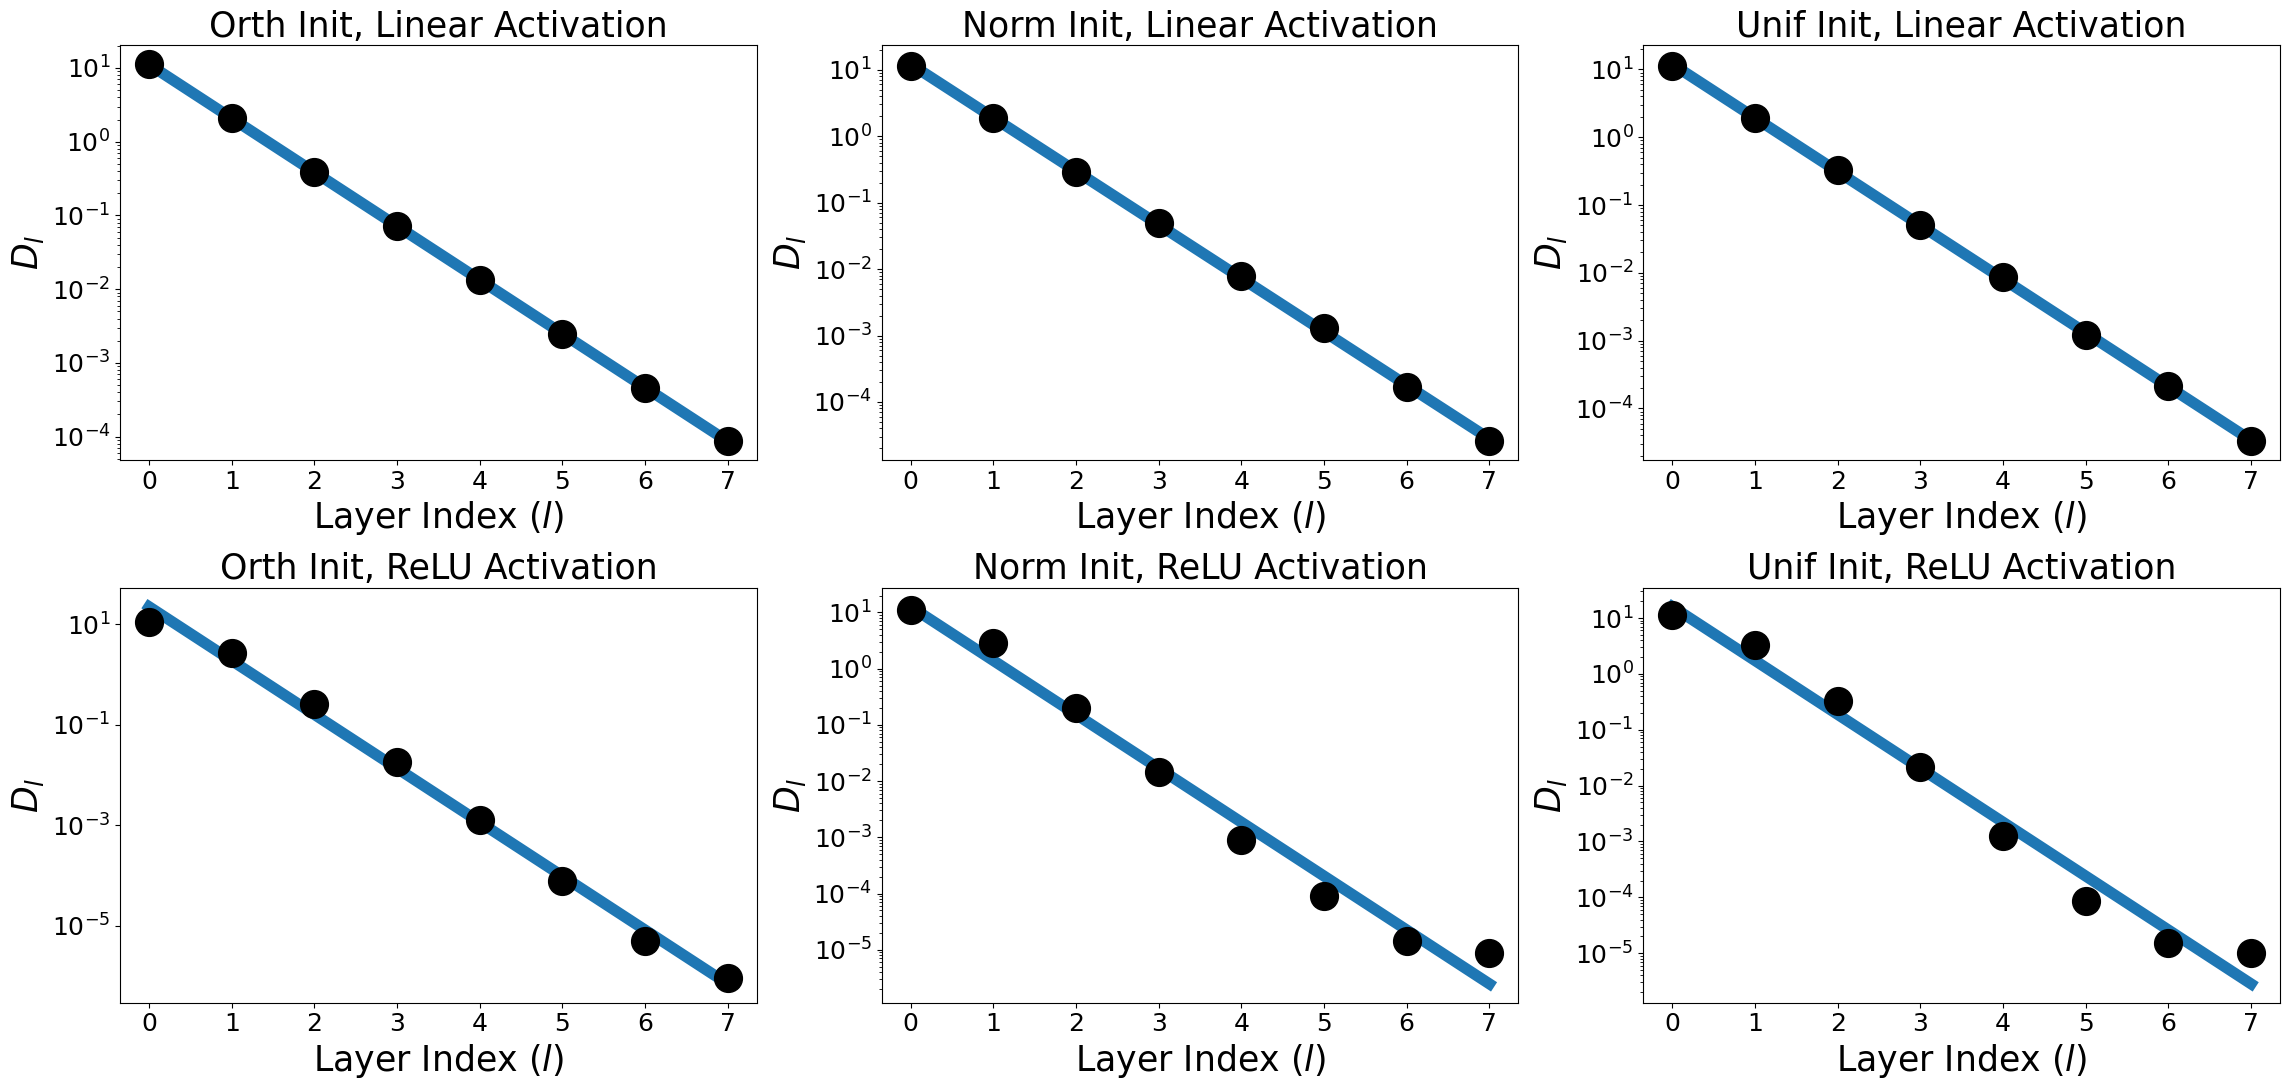

In [4]:
i = 0
fig = plt.figure(figsize=(23, 11))
init_scale = 0.5
depth = 8
step_size = 1

init_names = ['Orth', 'Norm', 'Unif']

for nonlinear in [False, True]:
    
    network_fn = nonlinear_network_fn if nonlinear else linear_network_fn
    for j, init_type in enumerate(['orth', 'norm', 'unif']):
        
        i += 1
        
        key, subkey = split(key)
        init_weights = init_net(
            key=subkey, 
            input_dim=input_dim, 
            output_dim=num_classes, 
            width=input_dim, 
            depth=depth, 
            init_scale=init_scale,
            init_type=init_type
        )
        
        result = train(
            init_weights=init_weights,
            network_fn=network_fn,
            loss_fn_dict=loss_fn_dict,
            n_outer_loops=n_outer_loops,
            step_size=step_size,
            tol=tol,
            n_inner_loops=n_inner_loops
        )

        final_weights = result['final_weights']
        intermediate_outputs = compute_outputs(final_weights, input_data, nonlinear=nonlinear)[1]

        feature_collapse_per_layer = jnp.array([
            compute_feature_collapse(inter_out, labels) for inter_out in intermediate_outputs
        ])
        
        ax = fig.add_subplot(2, 3, i)
        ax.semilogy(best_fit_line(feature_collapse_per_layer), c='tab:blue', linewidth=8)
        ax.semilogy(feature_collapse_per_layer, 'o', c='black', markersize=20)
        ax.set_xlabel(r'Layer Index ($l$)', fontsize=25)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_ylabel('$D_l$', fontsize=25)
        ax.set_title(f'{init_names[j]} Init, ' + ('ReLU' if nonlinear else 'Linear') + ' Activation', fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=18)

fig.tight_layout()
plt.savefig('figs/init_type_collapse.png', dpi=300, bbox_inches='tight')